# Data Science Wordclouds - DONE

This is a notebook for showing and testing the ability to produce wordclouds easily with the Visualize class.

---

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from PIL import Image
import wordcloud
import matplotlib.pyplot as plt

# helper modules and classes
from util import dataloader
from util import grid_models
from util.grid_models import custom_stop_words, get_random_class_labels
from util.reddit_functions import Visualizer

%load_ext autoreload
%autoreload 2

%matplotlib inline

!pwd

/Users/chris/github/reddit_nlp/util


In [10]:
# list to get data for
labels = get_random_class_labels(4)
print(labels)

df = dataloader.data_selector(labels, data_source='sqlite')

# what we expected?
df.sample(10)

['apachespark' 'machinelearning' 'datascience' 'scala']
Connection to SQLite DB successful


,title,subreddit,date
119,I think I've created the best configuration li...,scala,2020-03-29
1367,Question: Is there any way to store data into ...,apachespark,2020-03-29
38969,What’s data science like in the big tech compa...,datascience,2020-04-27
1451,Monthly Apache Spark Newsletter,apachespark,2020-03-29
3748,sbt 1.3.9 is released,scala,2020-04-02
140,A useful short snippet for anyone looking to r...,scala,2020-03-29
2152,"Favorite ""engineering notebook tools"" for DS/ML?",datascience,2020-03-29
2131,Do you think his series of courses is worth ta...,datascience,2020-03-29
1233,Packaging code with PEX — a PySpark example,apachespark,2020-03-29
3056,[Project] I've compiled weather/climate date f...,machinelearning,2020-03-29


In [11]:
# use defined Visualizer to produce images
viz = Visualizer(df=df, text_column='title', labels_column='subreddit')

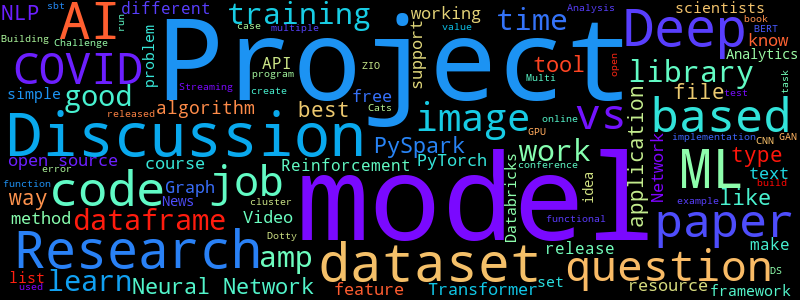

In [12]:
viz.make_cloud(stopwords=custom_stop_words, colormap='rainbow')

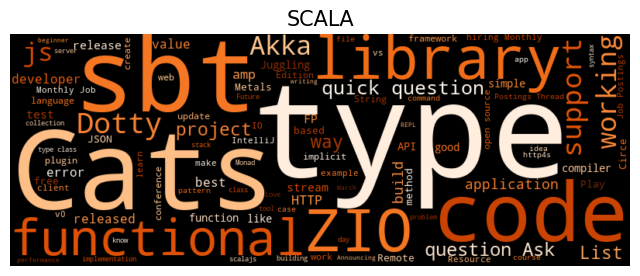

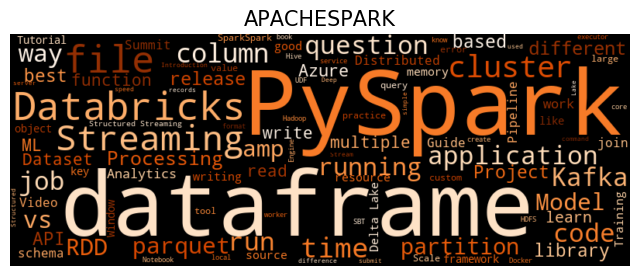

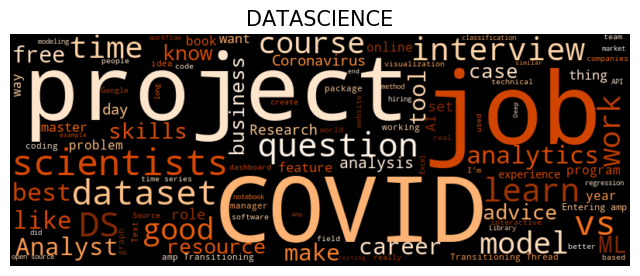

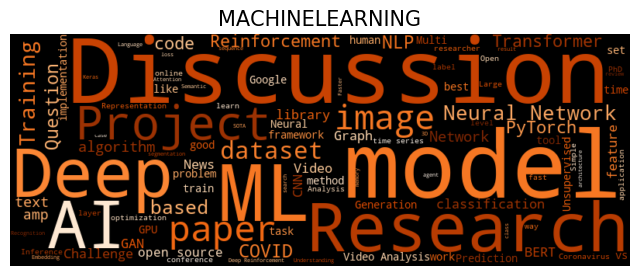

In [13]:
viz.make_cloud(labels_column='subreddit', split=True, stopwords=custom_stop_words, colormap='random', background_color='black')

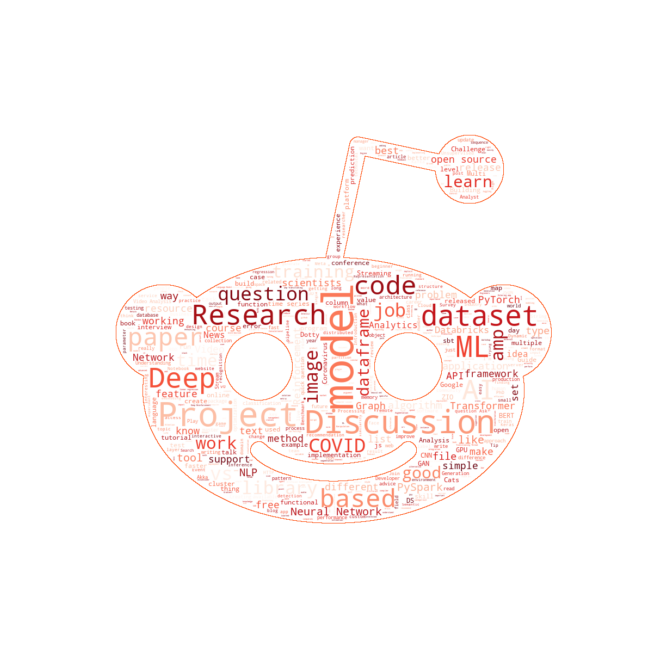

In [14]:
# change the image for a different outline
# flip the '<' in the mask to invert the mask
img = Image.open('../images/reddit03.png')
gray = np.array(img.convert('L'))
mask = np.where(gray < 200, 255, 0)

wc = wordcloud.WordCloud(background_color='white', 
                         max_words=500, 
                         mask=mask, 
                         colormap='Reds',
                         contour_color='orangered',
                         contour_width=1,
                         stopwords=custom_stop_words)
wc.generate(df['title'].str.cat())
plt.figure(figsize=(12,12))
plt.imshow(wc, interpolation='bilinear')
plt.axis(False);

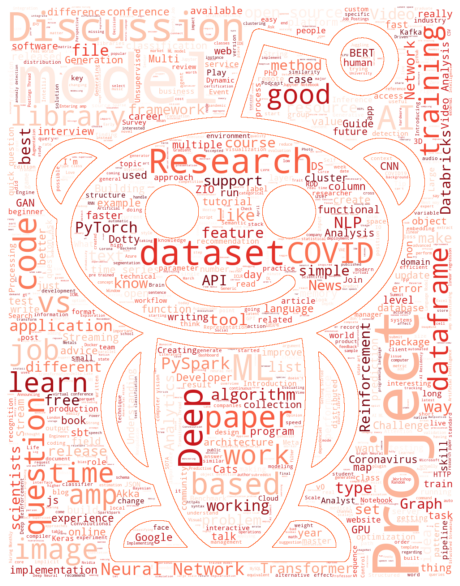

In [15]:
img2 = Image.open('../images/reddit02.jpg')
gray2 = np.array(img2.convert('L'))
mask2 = np.where(gray2 < 200, 255, 0)

wc2 = wordcloud.WordCloud(background_color='white', 
                         max_words=1000, 
                         mask=mask2, 
                         colormap='Reds',
                         contour_color='orangered',
                         contour_width=1,
                         stopwords=custom_stop_words)
wc2.generate(df['title'].str.cat())
plt.figure(figsize=(8,12))
plt.imshow(wc2, interpolation='bilinear')
plt.axis(False)

plt.show()

<Figure size 504x504 with 0 Axes>

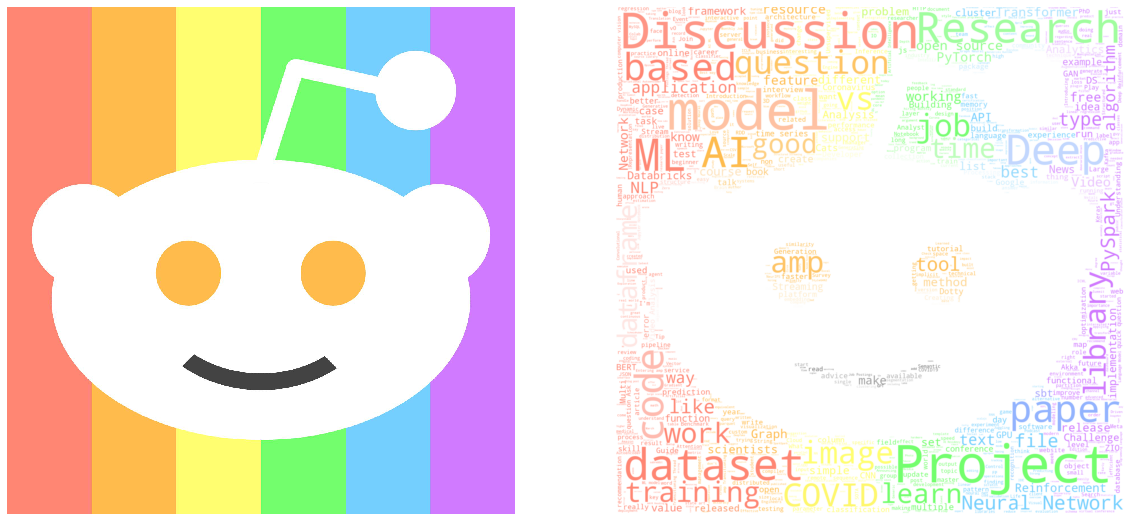

In [16]:
mask = np.array(Image.open("../images/reddit06.jpg"))
colorcloud = wordcloud.WordCloud(stopwords=custom_stop_words,
                                 background_color="white",
                                 mode="RGBA",
                                 max_words=1000,
                                 mask=mask)
colorcloud.generate(df['title'].str.cat())

image_colors = wordcloud.ImageColorGenerator(mask)
plt.figure(figsize=[7, 7])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

ax1.imshow(mask)
ax1.axis(False)

ax2.imshow(colorcloud.recolor(color_func=image_colors),
           interpolation="bilinear")
ax2.axis(False)

plt.show();